Loading Data...

--- Summary Results (Women 25-49) ---
                   Median Age
Location                     
Rwamagana                22.9
Nyagatare                22.1
Gatsibo                  22.1
Kayonza                  21.9
Kirehe                   22.4
Ngoma                    22.3
Bugesera                 22.4
Eastern Province         22.3
Rwanda (National)        23.0
✅ JSON saved: eastern_Median_Age_First_Birth.json
✅ Plot saved: Eastern_Median_Age_First_Birth.png


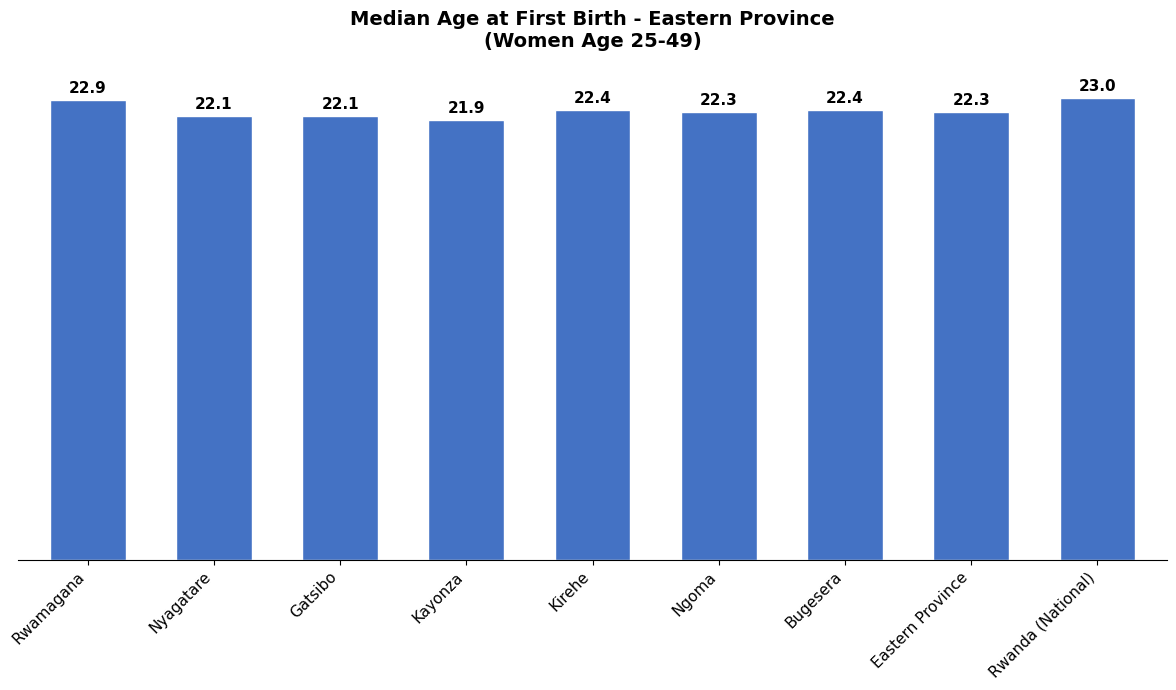

In [1]:
#!/usr/bin/env python3
# dhs_median_age_first_birth_eastern.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

# Variable Map
VAR_WT       = "v005"       # Weight
VAR_AGE      = "v012"       # Current Age
VAR_AGE_BIRTH= "v212"       # Age at first birth
VAR_TOTAL_KIDS="v201"       # Total children ever born
VAR_REG      = "v024"       # Region
VAR_DIST     = "sdistrict"  # District

# Eastern Province Districts
DIST_MAP = {
    51: 'Rwamagana', 
    52: 'Nyagatare', 
    53: 'Gatsibo',
    54: 'Kayonza',
    55: 'Kirehe',
    56: 'Ngoma',
    57: 'Bugesera'
}

# Colors: 7 Districts (Blue), Province (Green), Rwanda (Orange)
BAR_COLORS = ["#4472C4"] * 7 + ["#00B050", "#ED7D31"]

# ------------------------------------------------------------------
# 2. CALCULATION: INTERPOLATED MEDIAN
# ------------------------------------------------------------------
def get_dhs_median(df, val_col, wt_col):
    """
    Calculates the 'Interpolated Median' exactly like DHS reports.
    Formula: Lower_Limit + ( (0.5 - Cum_Freq_Prev) / Freq_Current ) * Width
    """
    if df.empty or df[wt_col].sum() == 0:
        return np.nan
    
    data = df[[val_col, wt_col]].copy()
    freq = data.groupby(val_col)[wt_col].sum().sort_index()
    
    total_wt = freq.sum()
    props = freq / total_wt
    cum_props = props.cumsum()
    
    try:
        # Find first index where cum_props >= 0.5
        median_bin = cum_props[cum_props >= 0.5].index[0]
    except IndexError:
        return np.nan 

    # If the median falls in the "Never gave birth" group (99), 
    # the median is technically "Undefined" (greater than current age)
    if median_bin == 99:
        return np.nan 

    idx_loc = cum_props.index.get_loc(median_bin)
    prop_prev = 0.0 if idx_loc == 0 else cum_props.iloc[idx_loc - 1]
    prop_curr = props.loc[median_bin]
    
    # Linear Interpolation
    median_val = median_bin + ( (0.5 - prop_prev) / prop_curr )
    return median_val

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found.")
        exit()

    print("Loading Data...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()
    
    # --- FILTERS ---
    # 1. Women Age 25-49 (DHS standard for age at first birth reports)
    df = df[(df[VAR_AGE] >= 25) & (df[VAR_AGE] <= 49)].copy()
    
    # 2. Weights
    df["w"] = df[VAR_WT] / 1000000.0

    # 3. Handle "Never Gave Birth" 
    # Assign age 99 so they are in the denominator but don't skew the median age lower
    df['calc_age'] = df[VAR_AGE_BIRTH]
    df.loc[df[VAR_TOTAL_KIDS] == 0, 'calc_age'] = 99

    # --- AGGREGATION ---
    results = {}

    # A. Districts (Eastern Province = Code 5)
    df_east = df[df[VAR_REG] == 5]
    for dist_code, dist_name in DIST_MAP.items():
        subset = df_east[df_east[VAR_DIST] == dist_code]
        results[dist_name] = get_dhs_median(subset, 'calc_age', 'w')

    # B. Eastern Province Total
    results["Eastern Province"] = get_dhs_median(df_east, 'calc_age', 'w')

    # C. Rwanda (National)
    results["Rwanda (National)"] = get_dhs_median(df, 'calc_age', 'w')

    # Convert to DataFrame
    final_df = pd.DataFrame(list(results.items()), columns=["Location", "Median Age"])
    final_df.set_index("Location", inplace=True)
    final_df["Median Age"] = final_df["Median Age"].round(1)

    print("\n--- Summary Results (Women 25-49) ---")
    print(final_df)

    # --- JSON OUTPUT ---
    json_name = "eastern_Median_Age_First_Birth.json"
    output_dict = {
        "indicator": "Median age at first birth among women age 25-49",
        "unit": "Years",
        "population": "Women age 25-49",
        "data": final_df["Median Age"].to_dict()
    }
    with open(json_name, "w") as f:
        json.dump(output_dict, f, indent=4)
    print(f"✅ JSON saved: {json_name}")

    # ------------------------------------------------------------------
    # 4. PLOTTING
    # ------------------------------------------------------------------
    ax = final_df.plot(kind="bar", legend=False, color=BAR_COLORS, figsize=(12, 7), 
                       width=0.6, edgecolor="white")

    plt.title("Median Age at First Birth - Eastern Province\n(Women Age 25-49)", 
              fontsize=14, fontweight="bold", pad=20)
    
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.xlabel("")
    plt.grid(axis="y", ls="--", alpha=0.3)
    
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: 
        ax.spines[s].set_visible(False)

    # Add Labels
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f', padding=3, fontsize=11, fontweight="bold")

    plt.tight_layout()
    plt.savefig("Eastern_Median_Age_First_Birth.png", dpi=300)
    print("✅ Plot saved: Eastern_Median_Age_First_Birth.png")